# The Planar Laplace mechanism

Here we implement the planar laplace mechanism to add laplace noise to any given 2d-coordinates. It's worth noting that polar coordinates are used to generate random laplace noise. In order to randomly draw r, we use the inverse CDF of r which is $$C_{\epsilon}(r) = \int_{0}^{r} D_{\epsilon, R} (\rho) d\rho = 1 - (1 + \epsilon r)e^{-\epsilon r}$$ as calculated in https://hal.inria.fr/hal-01114241/file/paper.pdf

In [8]:
import random
from scipy import special
import scipy
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [7]:
def random_laplace_noise(eps):
    '''
    Given epsilon > 0, this function returns relative 
    coordinates of the generated laplace noise, which 
    follows a planer laplace distribution centered at
    x with epsilon as the scale.
    '''
    # generate polar coordinates
    theta = np.random.uniform(0, 2*math.pi) # this shall be the angular coordinate
    
    p = random.random() # draw a random sample from unif(0, 1)
    r = -1/eps * (scipy.special.lambertw((p-1)/math.e, k=-1, tol=1e-8).real + 1) #this shall be the radial coordinate
    
    # convert polar coordinates to cartesian coordinates
    x, y = r * math.cos(theta), r * math.sin(theta)
    
    return x, y

## A Quick Demo

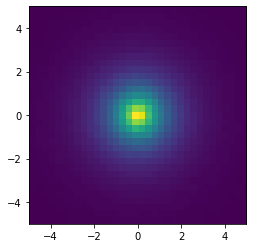

In [8]:
# Verify our algorithm using monte carlo simulation.

x_list = []
y_list = []
eps = 1

for i in range(10**6):
    noise = random_laplace_noise(eps)
    x_list.append(noise[0])
    y_list.append(noise[1])
    
# Use heatmap to visualize the distribution of generated laplace noise
heatmap, xedges, yedges = np.histogram2d(x_list, y_list, bins=100)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

# Geo-Indistinguishable Mechanisms of Optimal Utility

\begin{align*}
Minimize:\ &\sum_{x,z\in \mathcal{X}} \pi_x k_{xz} d_Q(x, z) \\
Subject\ to:\ &k_{xz} \leq e^{\epsilon d_{\mathcal{X}}(x, x')} k_{x' z} &x,x',z\in \mathcal{X} \tag{1}\\
&\sum_{z\in \mathcal{X}} k_{xz} = 1 & x\in \mathcal{X} \tag{2}\\
&k_{xz} \geq 0 &x, z\in \mathcal{X} \tag{3}
\end{align*}

In [1]:
import gurobipy as gp
from gurobipy import GRB

In [2]:
# We use euclidean distance to simplify the computation. 
# metrics such as manhattan distance and calculation methods such as 
# haversine formula can be used to substitute this function.
def dist(pt1, pt2):
    x_diff = pt1[0] - pt2[0]
    y_diff = pt1[1] - pt2[1]
    return math.sqrt(pow(x_diff, 2) + pow(y_diff, 2))

In [3]:
def optql(x_list, pi_list, dQ, epsilon=0.5):
    '''
    input: x_list: list of geographic coordinates
           pi_list: probability distribution for x_list
           dQ: distance metric
           epsilon: desired privacy level
    
    output: matrix: stochastic transition matrix
            pre_prob: normalized pre-process probability distribution
            post_prob: post-process probability distribution
    '''
    
    pre_prob = np.array(pi_list) / sum(pi_list) # normalize probability distribution
    n = len(x_list) # get number of elements
    threshold = math.exp(epsilon)
    
    # define a model
    model = gp.Model('OptQL')
    
    # add variables accessed as (0, 0), (0, 1), (1, 1), ...
    variables = model.addVars(n, n, lb=0.0, ub=1.0, name='k')
    
    # set objective function
    model.setObjective(gp.quicksum(pre_prob[i] * variables[i, j] * dQ(x_list[i], x_list[j]) \
                                   for i in range(n) for j in range(n)), GRB.MINIMIZE)
    
    # add constraints (1)
    model.addConstrs(variables[i, k] <= pow(threshold, dQ(x_list[i], x_list[j])) * variables[j, k] \
                     for i in range(n) for j in range(n) for k in range(n))
    
    # add constraints (2)
    model.addConstrs(gp.quicksum(variables.select(i, '*')) == 1 for i in range(n))
    
    # constriants (3) are already satisfied
    
    # optimize the model
    model.optimize()
    
    # build a matrix to store the stochastic matrix
    variables = model.getAttr('x', variables)
    matrix = np.zeros((n, n))
    for key, value in variables.items():
        matrix[key] = value
    
    # get post-process probability distribution
    post_prob = pre_prob @ matrix
    
    
    return matrix, pre_prob, post_prob

## A Quick Demo

In [47]:
import plotly.figure_factory as ff
import pandas as pd
import geopandas as gpd
import json
import osmnx as ox

In [161]:
all_zones = gpd.read_file('data/ZIP_Codes.geojson')
all_zones['Centroids'] = all_zones['geometry'].apply(lambda x: x.centroid)
sample = all_zones

In [162]:
x_list = [(lon, lat) for (lon, lat) in sample['Centroids'].apply(lambda x: (x.xy[0][0], x.xy[1][0]))]
pi_list = [geometry.area for geometry in sample['geometry']]
#pi_list = [1 for _ in range(len(x_list))]
dQ = lambda *args: dist(*args) * 69 # approximately convert distance between (lon, lat) coordinates to miles
epsilon = 0.5

p_matrix, pre_prob, post_prob = optql(x_list, pi_list, dQ, epsilon=epsilon)

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 79550 rows, 1849 columns and 157165 nonzeros
Model fingerprint: 0x9b7cb7c7
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [3e-08, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 1849 rows and 0 columns
Presolve removed 0 rows and 1849 columns
Presolve time: 0.41s
Presolved: 1849 rows, 79550 columns, 159014 nonzeros

Ordering time: 0.18s

Barrier statistics:
 Free vars  : 43
 AA' NZ     : 7.766e+04
 Factor NZ  : 1.145e+06 (roughly 40 MBytes of memory)
 Factor Ops : 9.082e+08 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.56756932e+04 -0.00000000e+0

In [163]:
import branca
import branca.colormap as cm
import folium

def reversed_colormap(existing):
    return cm.LinearColormap(
        colors=list(reversed(existing.colors)),
        vmin=existing.vmin, vmax=existing.vmax
    )
step = branca.colormap.linear.RdYlGn_10.to_step(6).scale(0, pre_prob.max()) 
step = reversed_colormap(step)
step.caption = 'Color Scale'

m = folium.Map(location=[42.36, -71.06], zoom_start=11.5, tiles='CartoDBpositron')

tmp = sample.copy(deep=True).drop('Centroids', axis=1)
tmp['pre_prob'] = pre_prob
folium.GeoJson(
    tmp,
    style_function=lambda feature: {
        'fill': True,
        'weight': 1,
        'opacity':1,
        'color': step(feature['properties']['pre_prob'])
    }
).add_to(m)
step.add_to(m)

m

In [164]:
step = branca.colormap.linear.RdYlGn_10.to_step(6).scale(0, post_prob.max()) 
step = reversed_colormap(step)
step.caption = 'Color Scale'

m = folium.Map(location=[42.36, -71.06], zoom_start=11.5, tiles='CartoDBpositron')

tmp = sample.copy(deep=True).drop('Centroids', axis=1)
tmp['post_prob'] = post_prob
folium.GeoJson(
    tmp,
    style_function=lambda feature: {
        'fill': True,
        'weight': 1,
        'opacity':1,
        'color': step(feature['properties']['post_prob'])
    }
).add_to(m)
step.add_to(m)

m

In [165]:
prob_diff = post_prob - pre_prob
step = branca.colormap.linear.RdYlGn_10.to_step(6).scale(prob_diff.min(), prob_diff.max()) 
step = reversed_colormap(step)
step.caption = 'Probability Difference (Post - Pre)'

m = folium.Map(location=[42.36, -71.06], zoom_start=11.5, tiles='CartoDBpositron')

tmp = sample.copy(deep=True).drop('Centroids', axis=1)
tmp['prob_diff'] = prob_diff
folium.GeoJson(
    tmp,
    style_function=lambda feature: {
        'fill': True,
        'weight': 1,
        'opacity':1,
        'color': step(feature['properties']['prob_diff'])
    }
).add_to(m)
step.add_to(m)

m

In [166]:
n = len(x_list)
dist_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        dist_matrix[i, j] = dQ(x_list[i], x_list[j])

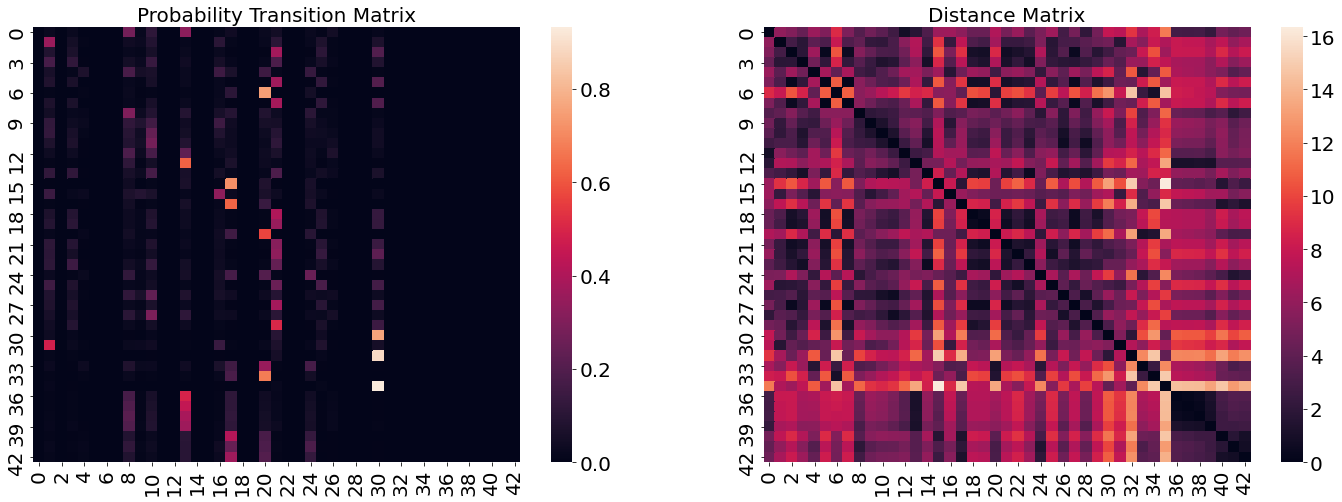

In [176]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

fig, axes = plt.subplots(1, 2, figsize=(24, 8))
sns.heatmap(p_matrix, annot=False, ax=axes[0])
sns.heatmap(dist_matrix, annot=False, ax=axes[1])
axes[0].set_title('Probability Transition Matrix', fontsize=20);
axes[1].set_title('Distance Matrix', fontsize=20);

In [53]:
import warnings
warnings.filterwarnings("ignore")

from keplergl import KeplerGl

map1 = KeplerGl()

prob_diff = post_prob - pre_prob
tmp = sample.copy(deep=True).drop('Centroids', axis=1)
tmp['prob_diff'] = prob_diff
tmp['pre_prob'] = pre_prob
tmp['post_prob'] = post_prob

equalizer = ox.geocode_to_gdf('Beijing, China').iloc[0, 0]
tmp.append(pd.Series(), ignore_index=True)
tmp.loc[len(tmp), 'geometry'] = equalizer
tmp.loc[len(tmp)-1, 'pre_prob'] = max(pre_prob.max(), post_prob.max())
tmp.loc[len(tmp)-2, 'post_prob'] = max(pre_prob.max(), post_prob.max())

map1.add_data(tmp, name='Differential Privacy on Boston Postal Zones')

with open('comparison_map_config_1.json', 'r') as f:
    config = json.load(f)
map1.config = config
map1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'bgrqu4b', 'type': …

## Graph Spanner Version for approximate optimal utility

\begin{align}
Minimize: \ &\sum_{x, z\in \mathcal{X}} \pi_x k_{xz} d_Q(x, z) \\
Subject\ to:\ & k_{xz} \leq e^{\frac{\epsilon}{\delta} d_G(x, x')} k_{x' z}  & z\in \mathcal{X}, (x, x') \in E  \tag{1} \\
& \sum_{x \in \mathcal{X}} k_{xz} = 1 & x\in\mathcal{X} \tag{2} \\
& k_{xz} \geq 0  &x,z\in \mathcal{X} \tag{3}
\end{align}

**The algorithm we used for constructing the graph spanner is from** <span style="color:gray">*S. Baswana, S. Sen. A Simple and Linear Time Randomized Algorithm for Computing Sparse Spanners in Weighted Graphs. Random Struct. Algorithms 30(4): 532-563 (2007).*</span> **implemented by** <span style="color:gray">*Aric A. Hagberg, Daniel A. Schult and Pieter J. Swart, “Exploring network structure, dynamics, and function using NetworkX”, in Proceedings of the 7th Python in Science Conference (SciPy2008), Gäel Varoquaux, Travis Vaught, and Jarrod Millman (Eds), (Pasadena, CA USA), pp. 11–15, Aug 2008.*</span>



In [67]:
import networkx as nx
from networkx.algorithms.sparsifiers import spanner

In [137]:
def optql_graph_spanner(x_list, pi_list, dQ, epsilon=0.5, delta=1.5):
    # Build a complete based on x_list
    G = nx.Graph()
    n = len(x_list)
    G.add_nodes_from(range(n))
    weighted_edges = [(i, j, dQ(x_list[i], x_list[j])) for i in range(n) for j in range(n)]
    G.add_weighted_edges_from(weighted_edges)
    
    # Construct a delta-spanner of x_list
    G = spanner(G, delta, weight='weight', seed=42)
    print(f"A {delta}-spanner graph with {len(G.edges)} edges")
    
    pre_prob = np.array(pi_list) / sum(pi_list) # normalize probability distribution
    threshold = math.exp(epsilon / delta)
    
    # define a model
    model = gp.Model('OptQL')
    
    # add variables accessed as (0, 0), (0, 1), (1, 1), ...
    variables = model.addVars(n, n, lb=0.0, ub=1.0, name='k')
    
    # set objective function
    model.setObjective(gp.quicksum(pre_prob[i] * variables[i, j] * dQ(x_list[i], x_list[j]) \
                                   for i in range(n) for j in range(n)), GRB.MINIMIZE)
    
    # add constraints (1)
    model.addConstrs(variables[i, k] <= pow(threshold, dQ(x_list[i], x_list[j])) * variables[j, k] \
                     for (i, j) in G.edges for k in range(n))
    model.addConstrs(variables[i, k] <= pow(threshold, dQ(x_list[i], x_list[j])) * variables[j, k] \
                     for (j, i) in G.edges for k in range(n))
    
    # add constraints (2)
    model.addConstrs(gp.quicksum(variables.select(i, '*')) == 1 for i in range(n))
    
    # constriants (3) are already satisfied
    
    # optimize the model
    model.optimize()
    
    # build a matrix to store the stochastic matrix
    variables = model.getAttr('x', variables)
    matrix = np.zeros((n, n))
    for key, value in variables.items():
        matrix[key] = value
    
    # get post-process probability distribution
    post_prob = pre_prob @ matrix
    
    
    return G, matrix, pre_prob, post_prob

In [140]:
sample = all_zones

In [158]:
x_list = [(lon, lat) for (lon, lat) in sample['Centroids'].apply(lambda x: (x.xy[0][0], x.xy[1][0]))]
pi_list = [geometry.area for geometry in sample['geometry']]
#pi_list = [1 for _ in range(len(x_list))]
dQ = lambda *args: dist(*args) * 69 # approximately convert distance between (lon, lat) coordinates to miles
epsilon = 0.5
delta = 3

G, p_matrix, pre_prob, post_prob = optql_graph_spanner(x_list, pi_list, dQ, epsilon=epsilon, delta=delta)

A 3-spanner graph with 407 edges
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 35045 rows, 1849 columns and 65833 nonzeros
Model fingerprint: 0x614e02d2
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [3e-08, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 3010 rows and 0 columns
Presolve removed 0 rows and 3010 columns
Presolve time: 0.09s
Presolved: 1849 rows, 33884 columns, 67682 nonzeros

Ordering time: 0.05s

Barrier statistics:
 Free vars  : 43
 AA' NZ     : 5.482e+04
 Factor NZ  : 8.672e+05 (roughly 20 MBytes of memory)
 Factor Ops : 5.116e+08 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0 

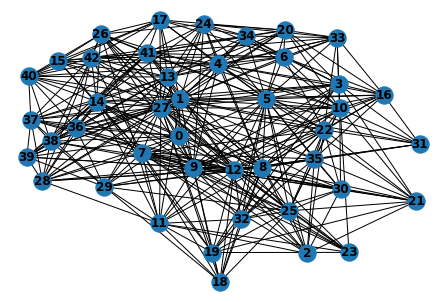

In [159]:
nx.draw(G, with_labels=True, font_weight='bold')

In [203]:
from shapely.geometry import LineString
import geojson
edges = [(x_list[i], x_list[j]) for i, j in G.edges]
edges = list(zip(*edges))
edges = pd.DataFrame({'Source_lon': list(zip(*edges[0]))[0], 
                      'Source_lat': list(zip(*edges[0]))[1], 
                      'Target_lon': list(zip(*edges[1]))[0],
                      'Target_lat': list(zip(*edges[1]))[1]})

In [206]:
map1 = KeplerGl()

prob_diff = post_prob - pre_prob
tmp = sample.copy(deep=True).drop('Centroids', axis=1)
tmp['prob_diff'] = prob_diff
tmp['pre_prob'] = pre_prob
tmp['post_prob'] = post_prob

equalizer = ox.geocode_to_gdf('Beijing, China').iloc[0, 0]
tmp.append(pd.Series(), ignore_index=True)
tmp.loc[len(tmp), 'geometry'] = equalizer
tmp.loc[len(tmp)-1, 'pre_prob'] = max(pre_prob.max(), post_prob.max())
tmp.loc[len(tmp)-2, 'post_prob'] = max(pre_prob.max(), post_prob.max())

map1.add_data(tmp, name='Differential Privacy on Boston Postal Zones')
map1.add_data(edges, name='Edges selected by the spanner')

with open('comparison_map_config_1.json', 'r') as f:
    config = json.load(f)
map1.config = config
map1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'bgrqu4b', 'type': …

In [208]:
map1.save_to_html(file_name='comparison_map_graph_spanner.html')

Map saved to comparison_map_graph_spanner.html!
